[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with ByteTrack Tracker


## Environment setup

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jan 22 10:32:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q trackers
!pip install -q inference-gpu

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.2 MB/s eta 0:00:00
     ━

In [3]:
!pip list | grep supervision
!pip list | grep trackers
!pip list | grep inference

supervision                              0.27.0
trackers                                 2.1.0
inference-gpu                            0.64.3
inference-models                         0.18.5


### Download example data

In [4]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4

### Import required packages

In [5]:
from inference import get_model
from trackers import ByteTrackTracker
import time
import supervision as sv
import numpy as np
from IPython.display import Video

ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.To suppress this warning, set CORE_MODEL_YOLO_WORLD_ENABLED to False.


# Track objects

### Initiate detector

In [6]:
model = get_model("rfdetr-medium")

Resolved model_id: coco/40, dataset_id: coco, version_id: 40


### Define tracker


In [7]:
# Initialize tracker
tracker = ByteTrackTracker()
tracker.reset()

### Define visualization colors and annotators

In [8]:
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=100)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)


### Define callback functions to track objects

In [9]:
frame_samples = []

def motorcycle_callback(frame: np.ndarray, i: int):
    # Obtain bounding box predictions from the detection model
    CONFIDENCE_THRESHOLD = 0.2 # To not show noisy predictions
    NMS_THRESHOLD = 0.3

    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)

    # Filter detections to only include motorcycle class
    detections = detections[detections.class_id == 4]

    # Update the tracker with the detections
    detections = tracker.update(detections)

    # Annotate the frame with the detections
    labels = [
        f"#{tracker_id}" if tracker_id is not None else "None"
        for tracker_id in detections.tracker_id
    ]
    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)
    return annotated_image

def track_with_bytetrack(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, callback):
    start = time.perf_counter()
    sv.process_video(
        source_path=SOURCE_VIDEO_PATH,
        target_path=TARGET_VIDEO_PATH,
        callback=callback,
        show_progress=True,
    )
    end = time.perf_counter()
    print("Total time",end-start)

## Run detection + tracking with only IoU

### Example: Motorcycles tracking

In [10]:
SOURCE_VIDEO_PATH = "/content/bikes-1280x720-1.mp4"
TARGET_VIDEO_PATH = "/content/bikes-1280x720-1-result-iou.mp4"

tracker.reset()
track_with_bytetrack(SOURCE_VIDEO_PATH, TARGET_VIDEO_PATH, motorcycle_callback)

Processing video:   0%|          | 0/388 [00:00<?, ?it/s]

Total time 19.907075289999966


In [11]:
#Compress the video for display in Google Colab
%%capture
!ffmpeg -y -i "/content/bikes-1280x720-1-result-iou.mp4" -vcodec libx264 -crf 28 compressed.mp4

In [12]:
#Display
Video("/content/compressed.mp4", embed=True,width = 900)

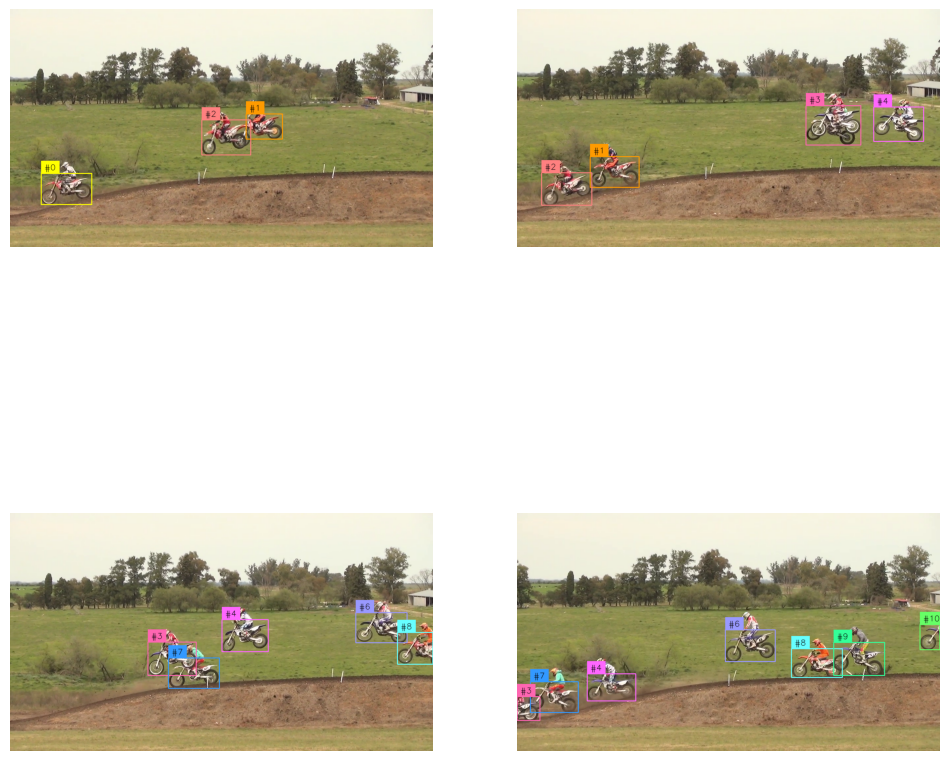

In [13]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

Just combined ByteTrack with RF-DETR, the SOTA object detector, and using `inference`—nice work! `trackers` makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including `inference`, `ultralytics`, and `transformers`.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/develop/) or dive into the code on [GitHub](https://github.com/roboflow/trackers). Got feedback or ideas, open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).